# Imports
<div style="width:100%;height:0;border-bottom: 3px solid #F59A31;margin-bottom: 1rem;"></div>


In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.cuda.amp import GradScaler, autocast
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from pathlib import Path
import cv2
from PIL import Image
import segmentation_models_pytorch as smp
from sklearn.model_selection import train_test_split
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchmetrics.image import StructuralSimilarityIndexMeasure as SSIM
from torchmetrics.regression import MeanSquaredError as MSE
from torchmetrics.collections import MetricCollection
import gc
from torchvision.transforms import Normalize

# Data & Visualization
### Note: brighter the area, farther it is in the image, brighter => more depth
<div style="width:100%;height:0;border-bottom: 3px solid #F7D735;margin-bottom: 1rem;"></div>


In [2]:
train_csv = Path('C:/Users/Torenia/.cache/kagglehub/datasets/soumikrakshit/nyu-depth-v2/versions/1/nyu_data/data/nyu2_train.csv')
train_ims_path = Path('C:/Users/Torenia/.cache/kagglehub/datasets/soumikrakshit/nyu-depth-v2/versions/1/nyu_data/data/nyu2_train')
base_path = Path('C:/Users/Torenia/.cache/kagglehub/datasets/soumikrakshit/nyu-depth-v2/versions/1/nyu_data')

In [3]:
df = pd.read_csv(train_csv,header=None)
df[0] = df[0].map(lambda x:base_path/x)
df[1] = df[1].map(lambda x:base_path/x)
df.head()

,0,1
0,C:\Users\Torenia\.cache\kagglehub\datasets\sou...,C:\Users\Torenia\.cache\kagglehub\datasets\sou...
1,C:\Users\Torenia\.cache\kagglehub\datasets\sou...,C:\Users\Torenia\.cache\kagglehub\datasets\sou...
2,C:\Users\Torenia\.cache\kagglehub\datasets\sou...,C:\Users\Torenia\.cache\kagglehub\datasets\sou...
3,C:\Users\Torenia\.cache\kagglehub\datasets\sou...,C:\Users\Torenia\.cache\kagglehub\datasets\sou...
4,C:\Users\Torenia\.cache\kagglehub\datasets\sou...,C:\Users\Torenia\.cache\kagglehub\datasets\sou...


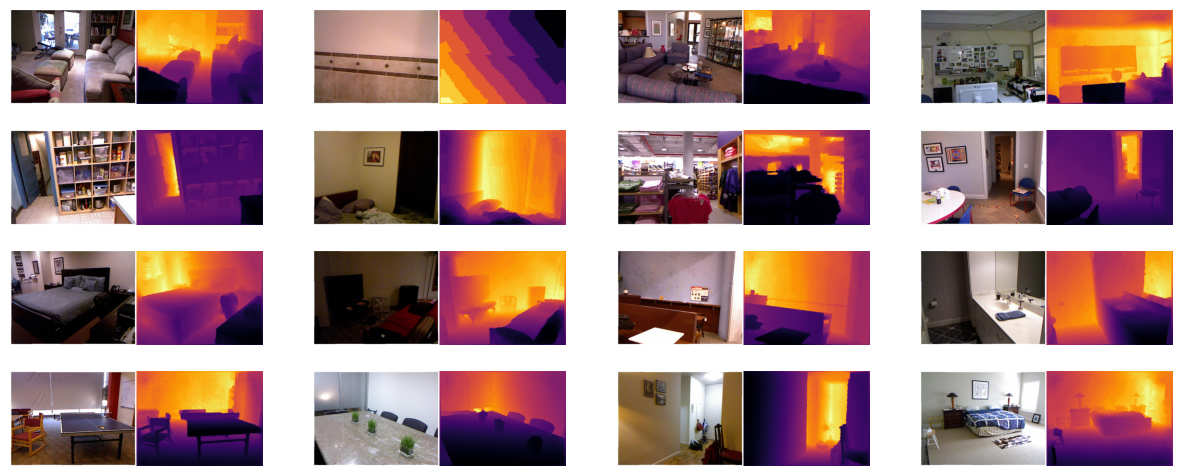

In [4]:
def colored_depthmap(depth, d_min=None, d_max=None,cmap=plt.cm.inferno):
    if d_min is None:
        d_min = np.min(depth)
    if d_max is None:
        d_max = np.max(depth)
    depth_relative = (depth - d_min) / (d_max - d_min)
    return 255 * cmap(depth_relative)[:,:,:3] # H, W, C

def merge_into_row(input, depth_target):
    input = np.array(input)
    depth_target = np.squeeze(np.array(depth_target))

    d_min = np.min(depth_target)
    d_max = np.max(depth_target)
    depth_target_col = colored_depthmap(depth_target, d_min, d_max)
    img_merge = np.hstack([input, depth_target_col])
    
    return img_merge

plt.figure(figsize=(15, 6))
for i, idx in enumerate(np.random.randint(0,len(df),(16,))):
    ax = plt.subplot(4, 4, i + 1)
    image = Image.open(df.iloc[idx,0]).convert('RGB')
    mask = Image.open(df.iloc[idx,1]).convert('L')
    image_viz = merge_into_row(
        image,mask
    )
    plt.imshow(image_viz.astype("uint8"))
    plt.axis("off")

# Model
<div style="width:100%;height:0;border-bottom: 3px solid #F7F437;margin-bottom: 1rem;"></div>


In [5]:
from transformers import AutoImageProcessor, AutoModelForDepthEstimation
import torch
import torch.nn as nn

model_name = "LiheYoung/depth-anything-small-hf"
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

processor = AutoImageProcessor.from_pretrained(model_name)
model = AutoModelForDepthEstimation.from_pretrained(model_name).to(device)


c:\Users\Torenia\.conda\envs\DepthAnythingTriangulation\lib\site-packages\huggingface_hub\file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Using device: cuda


# Dataset and Overlay
<div style="width:100%;height:0;border-bottom: 3px solid #F7F437;margin-bottom: 1rem;"></div>


In [6]:
class Dataset:
    def __init__(self,df,tfms):
        self.df = df
        self.tfms=tfms
    def open_im(self,p,gray=False):
        im = cv.imread(str(p))
        im = cv.cvtColor(im,cv.COLOR_BGR2GRAY if gray else cv.COLOR_BGR2RGB)
        return im
    
    def __len__(self,):
        return len(self.df)
    
    def __getitem__(self,idx):
        s = self.df.iloc[idx,:]
        im, dp = s[0],s[1]
        im, dp = self.open_im(im), self.open_im(dp,True)
        augs = self.tfms(image=im,mask=dp)
        im, dp = augs['image'], augs['mask'] / 255.
        return im, dp.unsqueeze(0)

In [7]:
class MaskOverlayDepthDataset(Dataset):
    def __init__(self, df, mask_path, apply_prob=1.0):
        self.df = df.reset_index(drop=True)
        self.mask = Image.open(mask_path).convert("L")  # grayscale mask
        self.apply_prob = apply_prob

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        rgb_path = self.df.iloc[idx, 0]
        depth_path = self.df.iloc[idx, 1]

        rgb = np.array(Image.open(rgb_path).convert("RGB")).astype(np.float32)
        depth = np.array(Image.open(depth_path).convert("L")).astype(np.float32)

        # Always apply mask (fixed occlusion)
        W, H = rgb.shape[1], rgb.shape[0]
        mask = self.mask.resize((W, H), Image.NEAREST)
        mask_arr = np.array(mask).astype(np.float32) / 255.0  # white=1 keep, black=0 mask

        rgb = rgb * mask_arr[..., None]  # apply mask

        # Convert to tensors [0..1]
        rgb_tensor = torch.from_numpy(rgb / 255.).permute(2,0,1)  # CHW
        depth_tensor = torch.from_numpy(depth).unsqueeze(0)

        return rgb_tensor, depth_tensor

In [8]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

mask_path = "C:/Users/Torenia/OneDrive/Documents/GitHub/JAIST/Depth Anything Triangulation/Code/Undistort-and-Depth/MaskTrain.png"

df_train, df_test = train_test_split(df, test_size=0.2, shuffle=True)

df_train = df_train.sample(n=100, random_state=42) #reduce for faster testing

df_train, df_val = train_test_split(df_train, test_size=0.1, shuffle=True)

train_ds = MaskOverlayDepthDataset(df_train, mask_path)
val_ds   = MaskOverlayDepthDataset(df_val,   mask_path)
test_ds  = MaskOverlayDepthDataset(df_test,  mask_path)

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=4, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=4, shuffle=True)

print("Train:", len(train_ds), "Val:", len(val_ds), "Test:", len(test_ds))

Train: 90 Val: 10 Test: 10138


# Transforms Visualization
<div style="width:100%;height:0;border-bottom: 3px solid #DEF839;margin-bottom: 1rem;"></div>

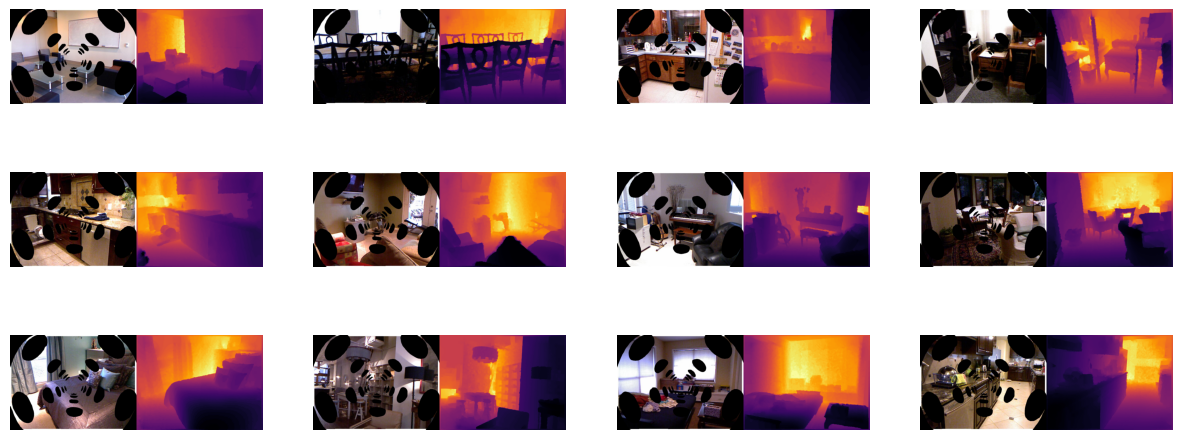

In [9]:
plt.figure(figsize=(15, 6))
for i in range(12):
    x, y = test_ds[i]

    # Un-normalize masked tensor back to [0,255] RGB
    rgb_masked = (x.permute(1,2,0).numpy() * 255).astype(np.uint8)

    # Load GT depth
    depth_gt = np.array(Image.open(test_ds.df.iloc[i, 1]).convert("L"))

    # Resize depth GT to match masked image height/width
    H, W = rgb_masked.shape[:2]
    depth_gt_resized = cv2.resize(depth_gt, (W, H), interpolation=cv2.INTER_NEAREST)

    viz = merge_into_row(rgb_masked, depth_gt_resized)

    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(viz.astype("uint8"))
    plt.axis("off")

# Training
<div style="width:100%;height:0;border-bottom: 3px solid #F59A31;margin-bottom: 1rem;"></div>

In [11]:
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
# loss_fn = nn.L1Loss()

# def evaluate():
#     model.eval()
#     total_loss = 0
#     with torch.no_grad():
#         for x, y in val_loader:   # ✅ use val set for eval
#             inputs = processor(
#                 images=x.permute(0,2,3,1).cpu().numpy(),
#                 return_tensors="pt"
#             ).to(device)

#             y = y.to(device)

#             pred = model(pixel_values=inputs["pixel_values"]).predicted_depth
#             pred = torch.nn.functional.interpolate(
#                 pred.unsqueeze(1),
#                 size=y.shape[-2:],
#                 mode="bilinear",
#                 align_corners=False
#             ).squeeze(1)
#             total_loss += loss_fn(pred, y).item()
#     return total_loss / len(val_loader)

# for epoch in range(1):
#     model.train()
#     running_loss = 0

#     for x, y in tqdm(train_loader):
#         inputs = processor(
#             images=x.permute(0,2,3,1).cpu().numpy(),
#             return_tensors="pt"
#         ).to(device)

#         y = y.to(device)

#         pred = model(pixel_values=inputs["pixel_values"]).predicted_depth
#         pred = torch.nn.functional.interpolate(
#             pred.unsqueeze(1),
#             size=y.shape[-2:],
#             mode="bilinear",
#             align_corners=False
#         ).squeeze(1)

#         loss = loss_fn(pred, y)

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#         running_loss += loss.item()

#     val_loss = evaluate()
#     print(f"Epoch {epoch+1} | Train Loss: {running_loss/len(train_loader):.4f} | Val: {val_loss:.4f}")

In [12]:
# save_path = "./DepthAnything_Masked_Finetuned"
# model.save_pretrained(save_path)
# processor.save_pretrained(save_path)
# print("Model saved to", save_path)

# Testing
<div style="width:100%;height:0;border-bottom: 3px solid #F7F437;margin-bottom: 1rem;"></div>


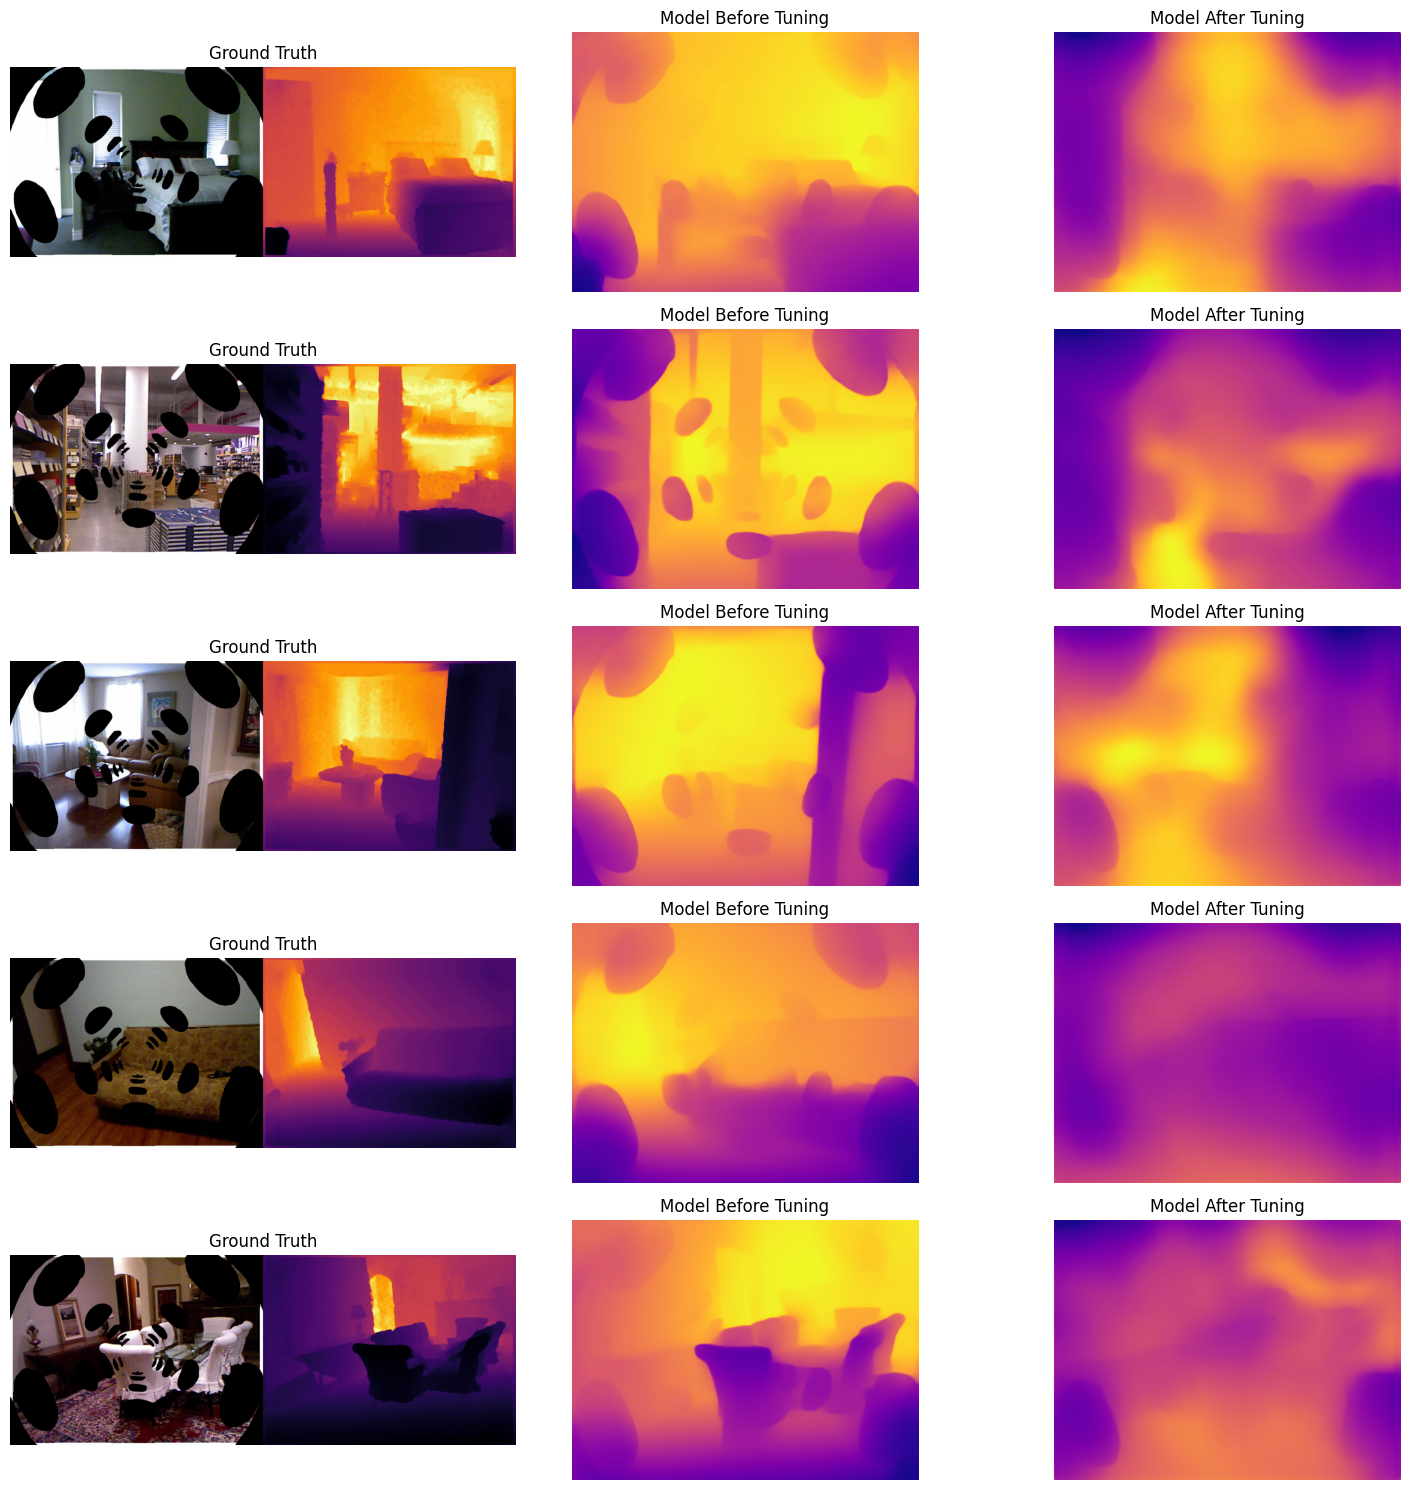

In [18]:
import random
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from transformers import AutoModelForDepthEstimation

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load models
model_before = AutoModelForDepthEstimation.from_pretrained(
    "LiheYoung/depth-anything-small-hf"
).to(device)
model_after = AutoModelForDepthEstimation.from_pretrained(
    "./DepthAnything_Masked_Finetuned"
).to(device)
model_before.eval()
model_after.eval()

def preprocess_image(rgb_np, max_size=518):
    """
    Resize while keeping aspect ratio, matching real-time pipeline logic.
    """
    H, W = rgb_np.shape[:2]
    scale = max_size / max(H, W)
    new_W, new_H = int(W * scale), int(H * scale)
    img_resized = cv2.resize(rgb_np, (new_W, new_H), interpolation=cv2.INTER_LINEAR)
    tensor = torch.from_numpy(img_resized).permute(2, 0, 1).unsqueeze(0).float().div_(255.0)
    return tensor.to(device), (H, W), (new_H, new_W)

def infer_depth(model, rgb_np):
    x, (orig_H, orig_W), (new_H, new_W) = preprocess_image(rgb_np)
    with torch.no_grad():
        with torch.amp.autocast(device_type="cuda", enabled=(device.type == "cuda")):
            pred = model(pixel_values=x).predicted_depth
    depth = pred.squeeze().detach().cpu().float().numpy()
    depth_resized = cv2.resize(depth, (orig_W, orig_H), interpolation=cv2.INTER_LINEAR)
    return depth_resized

def normalize_depth(depth, invert=True):
    """
    Normalize depth to [0, 255]. If invert=True, make near objects bright.
    """
    depth_norm = cv2.normalize(depth, None, 0, 255, cv2.NORM_MINMAX)
    if invert:
        depth_norm = 255 - depth_norm  # ✅ invert brightness
    return np.clip(depth_norm, 0, 255).astype(np.uint8)

# Random test samples
N = 5
indices = random.sample(range(len(test_ds)), N)

plt.figure(figsize=(15, N * 3))
for i, idx in enumerate(indices):
    rgb, depth_gt = test_ds[idx]
    rgb_np = (rgb.permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8)
    depth_gt_np = depth_gt.squeeze().cpu().numpy()

    # --- Model Before Tuning ---
    pred_b = infer_depth(model_before, rgb_np)
    pred_b_color = cv2.applyColorMap(normalize_depth(pred_b, invert=True), cv2.COLORMAP_PLASMA)

    # --- Model After Tuning ---
    pred_a = infer_depth(model_after, rgb_np)
    pred_a_color = cv2.applyColorMap(normalize_depth(pred_a, invert=True), cv2.COLORMAP_PLASMA)

    # --- Visualization ---
    plt.subplot(N, 3, i * 3 + 1)
    plt.imshow(merge_into_row(rgb_np, depth_gt_np).astype("uint8"))
    plt.title("Ground Truth")
    plt.axis("off")

    plt.subplot(N, 3, i * 3 + 2)
    plt.imshow(pred_b_color[..., ::-1])  # BGR→RGB
    plt.title("Model Before Tuning")
    plt.axis("off")

    plt.subplot(N, 3, i * 3 + 3)
    plt.imshow(pred_a_color[..., ::-1])
    plt.title("Model After Tuning")
    plt.axis("off")

plt.tight_layout()
plt.show()